In [ ]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sys
import gzip
import datetime
from tabulate import tabulate

In [ ]:
FIGSIZE = (6,3)

seed_value = 42  # seed for reproducibility
random.seed(seed_value)
subsample_ratio = 0.05

n = 40428967  # total number of records in the clickstream data
sample_size = int(n * subsample_ratio)

parse_date = lambda val : datetime.datetime.strptime(val, '%y%m%d%H')
skip_values = lambda i: i>0 and random.random() > subsample_ratio

In [ ]:
# indicate the datatypes to use in the reading process
types_train = {
    'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.dtype(int),
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str),
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21':np.dtype(int)
}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings(action='ignore')
# warnings.filterwarnings(action='default')

In [ ]:
with gzip.open('/content/drive/MyDrive/ctr/avazu-gzip/train.gz') as f:
    train = pd.read_csv(f, parse_dates = ['hour'], date_parser = parse_date, dtype=types_train, skiprows=skip_values)
# with gzip.open('/content/sample_data/avazu/train.gz') as f:
#     train = pd.read_csv(f, parse_dates = ['hour'], date_parser = parse_date, dtype=types_train, skiprows=skip_values)

In [ ]:
class Feature_Analysis:
    def __init__(self, feature_name, train, figsize=(12,6)):
        self.feature_name = feature_name
        self.train = train
        self.figsize = figsize

    def ret_top10_class_info(self):
        print("There are {} {} in the data set".format(train[self.feature_name].nunique(), self.feature_name))
        self.top10_class_info = train[self.feature_name].value_counts()[:10] / len(train) * 100
        self.top10_class = self.top10_class_info.index
        self.click_avg_list = []

        for class_val in self.top10_class:
            click_avg = self.train.loc[np.where((self.train[self.feature_name] == class_val))].click.mean() * 100
            self.click_avg_list.append(click_avg)

        data = {'frequency' : self.top10_class_info, 'CTR' : self.click_avg_list}
        self.top10_summary_df = pd.DataFrame(data = data).reset_index()
        print(tabulate(self.top10_summary_df, headers='keys', tablefmt='psql', floatfmt=".2f"))

    def top10_class_histogram(self):
        self.top10_histogram = self.train[(self.train[self.feature_name].isin(self.top10_class))]
        self.top10_histogram_click = self.top10_histogram[self.top10_histogram['click'] == 1]
        self.top10_histogram.groupby([self.feature_name, 'click']).size().unstack().reindex(self.top10_class).plot(kind='bar', figsize=self.figsize, title='Top 10 {} histogram'.format(self.feature_name));

    def top10_CTR(self):
        self.df_feature = self.top10_histogram[[self.feature_name, 'click']].groupby([self.feature_name]).count().reset_index()
        self.df_feature = self.df_feature.rename(columns={'click':'impressions'})
        self.df_feature['clicks'] = self.top10_histogram_click[[self.feature_name, 'click']].groupby(self.feature_name).count().reset_index()['click']
        self.df_feature['CTR'] = self.df_feature['clicks'] / self.df_feature['impressions'] * 100
        self.df_feature['CTR'] = self.df_feature['CTR'].apply(lambda x: 0 if x > 100 else x)
        self.df_feature.replace(np.nan, 0, inplace=True)

        pal = sns.color_palette("Greens_d", len(self.df_feature))
        rank = self.df_feature.sort_values(by='impressions', ascending=False)['CTR'].argsort().argsort()

        plt.figure(figsize=self.figsize)
        sns.barplot(y='CTR', x=self.feature_name, data=self.df_feature, order=self.top10_class, palette=np.array(pal)[rank])
        plt.xticks(rotation=70)
        plt.title("CTR by Top 10 {}".format(self.feature_name))

In [ ]:
def analysis_feature(feature_name):
    analysis = Feature_Analysis(feature_name, train, (6,3))
    analysis.ret_top10_class_info()
    analysis.top10_class_histogram()
    analysis.top10_CTR()
    return analysis

In [ ]:
train.shape

(2020327, 24)

In [ ]:
train.dtypes

,0
id,uint64
click,int64
hour,datetime64[ns]
C1,int64
banner_pos,int64
site_id,object
site_domain,object
site_category,object
app_id,object
app_domain,object


In [ ]:
# 결측치 확인
pd.DataFrame(train.isnull().sum())

,0
id,0
click,0
hour,0
C1,0
banner_pos,0
site_id,0
site_domain,0
site_category,0
app_id,0
app_domain,0


<h2>Feature Category</h2>
Target Feature : Click <br>
Site Features : site_id, site_domain, site_category <br>
App Features : app_id, app_domain, app_category <br>
Device Features : device_id, device_ip, device_model, device_type, device_conn_type <br>
Anomyized Categorical Features : C1, C14-21 <br>


<h1>Click Analysis </h1>

In [ ]:
# Check Non-click, Click Counts
train['click'].value_counts()

,count
click,
0,1677274
1,343053


In [ ]:
# Check Ratio
train['click'].value_counts() / len(train)

,count
click,
0,0.830199
1,0.169801


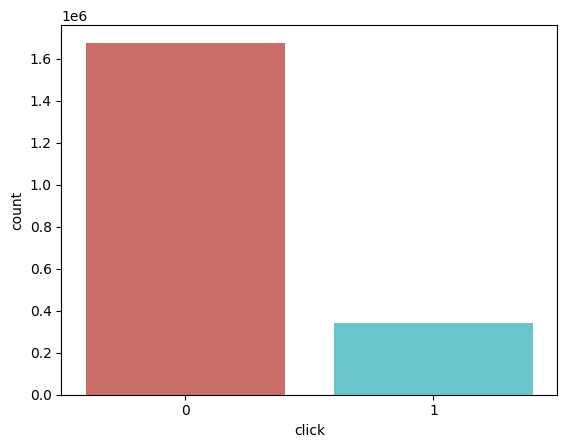

In [ ]:
sns.countplot(x='click', data=train, palette='hls')
plt.show()

CTR is approx. 17% <br>
Non CTR is approx. 83%

<h1>Hour Analysis</h1>

In [ ]:
train.hour.describe()

,hour
count,2020327
mean,2014-10-25 22:31:28.256109056
min,2014-10-21 00:00:00
25%,2014-10-23 04:00:00
50%,2014-10-26 02:00:00
75%,2014-10-28 14:00:00
max,2014-10-30 23:00:00


Data covers 10 Days - 2014.10.21 ~ 2014.10.30 <br>
Every time data is stamped in hour unit. There is unique 240 hours

Text(0.5, 1.0, 'Number of Clicks by Hour')

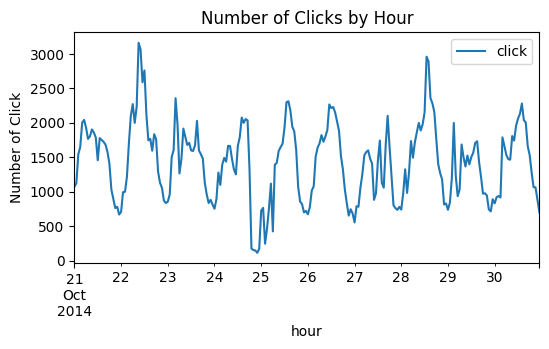

In [ ]:
train.groupby('hour').agg({'click':'sum'}).plot(figsize=FIGSIZE)
plt.ylabel('Number of Click')
plt.title('Number of Clicks by Hour')

In [ ]:
# Average click counts per hour
train.groupby('hour').agg({'click':'sum'}).mean().astype(int)

,0
click,1429


In [ ]:
train.groupby('hour').agg({'click':'sum'}).sort_values('click',ascending=False).head()

,click
hour,
2014-10-22 09:00:00,3163
2014-10-22 10:00:00,3067
2014-10-28 13:00:00,2962
2014-10-28 14:00:00,2894
2014-10-22 12:00:00,2762


In [ ]:
train.groupby('hour').agg({'click':'sum'}).sort_values('click').head()

,click
hour,
2014-10-24 22:00:00,113
2014-10-24 21:00:00,147
2014-10-24 20:00:00,153
2014-10-24 23:00:00,173
2014-10-24 19:00:00,174


Average click counts per hour : 1429 <br>
Top click counts : 3163 <br>
Lowest click counts : 113

<h2> Feature Engineering for date time features</h2>

<h3>Analysis on hour</h3>

Text(0.5, 1.0, 'Click Trends by Hour of Day')

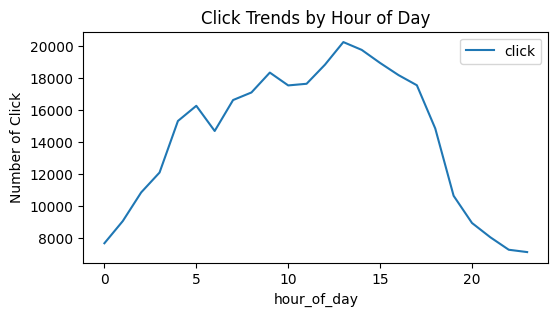

In [ ]:
# Extract hour from date time feature
train['hour_of_day'] = train.hour.apply(lambda x : x.hour)
train.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=FIGSIZE)
plt.ylabel("Number of Click")
plt.title("Click Trends by Hour of Day")

High points around 12~13 hour <br>
Low points around 0, 24 hour

In [ ]:
train.groupby('hour_of_day').agg({'click':'sum'}).mean().astype(int)

,0
click,14293


In [ ]:
train.groupby('hour_of_day').agg({'click':'sum'}).sort_values('click', ascending=False).head(3)

,click
hour_of_day,
13,20224
14,19736
15,18919


In [ ]:
train.groupby('hour_of_day').agg({'click':'sum'}).sort_values('click').head(3)

,click
hour_of_day,
23,7102
22,7248
0,7654


<h2> CTR Trend by Hour of Day </h2>

In [ ]:
df_click = train[train['click'] == 1]
df_hour = train[['hour_of_day', 'click']].groupby(['hour_of_day']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['hour_of_day', 'click']].groupby(['hour_of_day']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks'] / df_hour['impressions'] * 100

Text(0.5, 1.0, 'CTR Trends by Hour of Day')

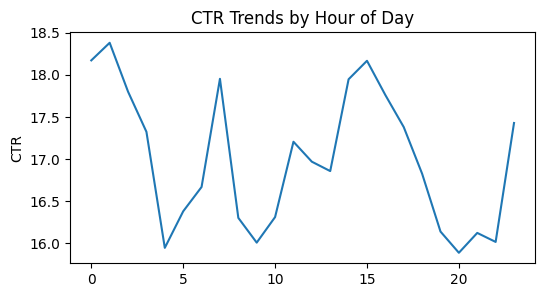

In [ ]:
df_hour['CTR'].plot(figsize=FIGSIZE)
plt.ylabel("CTR")
plt.title("CTR Trends by Hour of Day")

In [ ]:
df_hour['CTR'].mean()

16.997246235118947

In [ ]:
df_hour['CTR'].sort_values(ascending=False).head(3)

,CTR
1,18.381994
0,18.172753
15,18.167937


In [ ]:
df_hour['CTR'].sort_values().head(3)

,CTR
20,15.885087
4,15.943706
9,16.005802


<b>Click Trends does not go along with CTR Trend</b> <br>
CTR trends reaches its top at 1, 15 <br>
Click trends reaches its lowest around 0

<h2>Day of Week</h2>

Text(0.5, 1.0, 'Click Trends by Day of Week')

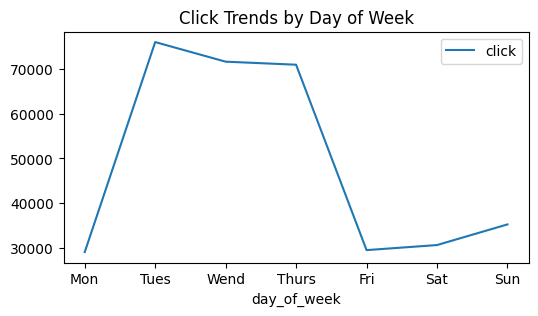

In [ ]:
train['day_of_week'] = train['hour'].apply(lambda val : val.strftime('%A'))
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train.groupby('day_of_week').agg({'click' : 'sum'}).reindex(cats).plot(figsize=FIGSIZE)
ticks = list(range(0, 7, 1))
labels = "Mon Tues Wend Thurs Fri Sat Sun".split(" ")
plt.xticks(ticks, labels)
plt.title("Click Trends by Day of Week")

Text(0.5, 1.0, 'Impressions VS Click Trends by day of week')

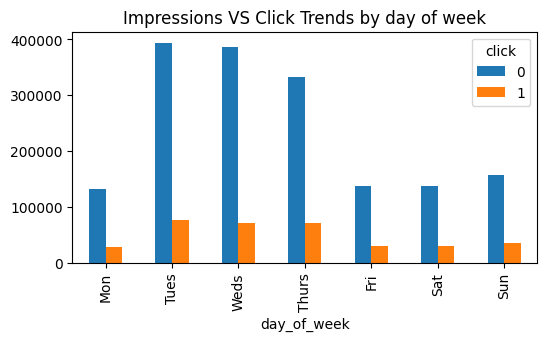

In [ ]:
# 나중에 삭제해도 됨. 해석이 잘 안되는 도표
train.groupby(['day_of_week', 'click']).size().unstack().reindex(cats).plot(kind='bar', title='Day of the Week', figsize=FIGSIZE)
ticks = list(range(0, 7, 1))
labels = "Mon Tues Weds Thurs Fri Sat Sun".split(' ')
plt.xticks(ticks, labels)
plt.title("Impressions VS Click Trends by day of week")

<h2>CTR Trends by Day of the week</h2>

In [ ]:
df_click = train[train['click'] == 1]
df_dayofweek = train[['day_of_week', 'click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'click' :'impressions'})
df_dayofweek['clicks'] = df_click[['day_of_week', 'click']].groupby(['day_of_week']).count().reset_index()['click']
df_dayofweek['CTR'] = df_dayofweek['clicks'] / df_dayofweek['impressions'] * 100

In [ ]:
df_dayofweek.set_index('day_of_week', inplace=True)

Text(0.5, 1.0, 'CTR Trends by Day of the week')

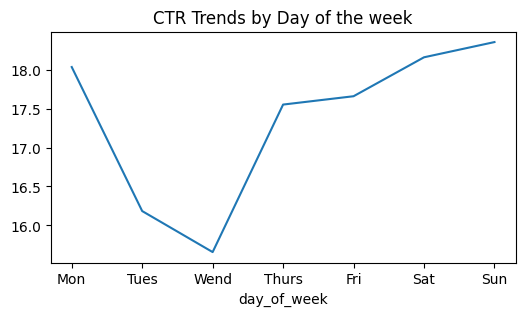

In [ ]:
df_dayofweek.reindex(cats)['CTR'].plot(figsize=FIGSIZE)
ticks = list(range(0, 7, 1))
labels = "Mon Tues Wend Thurs Fri Sat Sun".split(" ")
plt.xticks(ticks, labels)
plt.title("CTR Trends by Day of the week")

In [ ]:
df_dayofweek['CTR'].mean()

17.37485268945095

In [ ]:
df_dayofweek['CTR'].sort_values(ascending=False).head(3)

,CTR
day_of_week,
Sunday,18.361579
Saturday,18.165458
Monday,18.040035


In [ ]:
df_dayofweek['CTR'].sort_values().head(3)

,CTR
day_of_week,
Wednesday,15.654361
Tuesday,16.183077
Thursday,17.555995


<b>Day of the Week에서도, CTR Trend와 Click Trend가 유사하지 않았다 </b> <br>
Click수가 적었던 Sat, Sun에는 CTR이 오히려 컸고 <br>
Click수가 많았던 Mon, Tue에는 CTR이 작았다 <br>
<b>요일별로 CTR의 편차가 있다 -> 요일도 Importance가 좋은 변수가 될 수 있다</b>

<b>나중 연구 주제</b> <br>
Class 평균 CTR의 Variation이 클수록 변수의 Importance가 커지지 않을까? <br>
CTR Variation과 Feature Importance의 상관관계 구해보면 좋을 것 같다

<h2>C1 Feature</h2>

There are 7 C1 in the data set
+----+---------+-------------+-------+
|    |      C1 |   frequency |   CTR |
|----+---------+-------------+-------|
|  0 | 1005.00 |       91.88 | 16.95 |
|  1 | 1002.00 |        5.50 | 20.77 |
|  2 | 1010.00 |        2.22 |  9.58 |
|  3 | 1012.00 |        0.28 | 16.71 |
|  4 | 1007.00 |        0.08 |  4.52 |
|  5 | 1001.00 |        0.02 |  3.29 |
|  6 | 1008.00 |        0.01 | 13.79 |
+----+---------+-------------+-------+


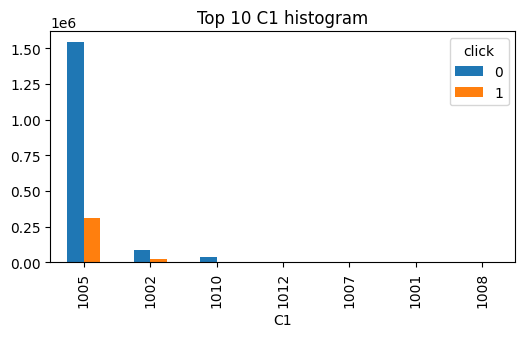

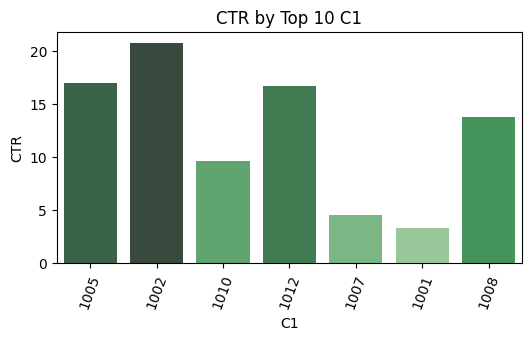

In [ ]:
FEATURE_NAME = 'C1'
analysis_feature(FEATURE_NAME)

C1 = 1002 인 Data의 CTR : 20.7% <br>
C1 = 1001 인 Data의 CTR : 3.2% <br>
평균 16%와 큰 차이가 있다. <br>

설명력 있는 Feature일 수 있다

<h2>Banner Position</h2>
광고가 어떤 위치에 있는지는 큰 영향을 미친다고 알려져있다. <br>
Avazu Dataset에서도 마찬가지인지 확인한다.

There are 7 banner_pos in the data set
+----+--------------+-------------+-------+
|    |   banner_pos |   frequency |   CTR |
|----+--------------+-------------+-------|
|  0 |         0.00 |       72.02 | 16.43 |
|  1 |         1.00 |       27.80 | 18.35 |
|  2 |         7.00 |        0.11 | 31.96 |
|  3 |         2.00 |        0.03 | 12.91 |
|  4 |         4.00 |        0.02 | 24.30 |
|  5 |         5.00 |        0.01 | 13.46 |
|  6 |         3.00 |        0.01 | 14.56 |
+----+--------------+-------------+-------+


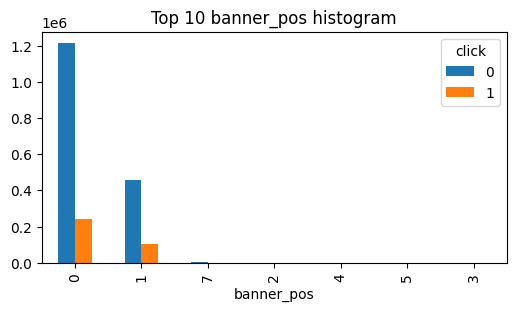

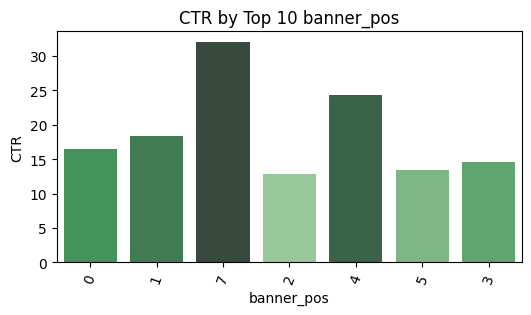

In [ ]:
FEATURE_NAME = 'banner_pos'
analysis_feature(FEATURE_NAME)

Position 0 - 72%, CTR: 16.43% <br>
Position 1 - 27%, CTR: 18.35% <br>

- 큰 변별력을 갖지 못하는거 아닐까? <br>
-- Position 0 을 갖는 Portion이 큰데, CTR은 평균 근처
-- Position 1 을 갖는 Portion은 27%로 작지 않다. CTR은 평균보다 2% 크다. 유의미할까?

7번 자리를 이용하는 광고의 비율 : 0.11% <br>
CTR이 31.96%로 평균 CTR 16%에 비해 많이 높지만, <br>
7번 자리의 Frequency가 높지 않기 때문에, 설명력이 좋은 Feature는 아니지 않을까?

<h2>Site Features</h2>

<h3>Site ID</h3>

There are 3056 site_id in the data set
+----+-----------+-------------+-------+
|    | site_id   |   frequency |   CTR |
|----+-----------+-------------+-------|
|  0 | 85f751fd  |       36.10 | 11.92 |
|  1 | 1fbe01fe  |       16.03 | 20.69 |
|  2 | e151e245  |        6.53 | 29.66 |
|  3 | d9750ee7  |        2.37 | 28.24 |
|  4 | 5b08c53b  |        2.25 | 46.41 |
|  5 | 856e6d3f  |        1.90 |  4.23 |
|  6 | 5b4d2eda  |        1.89 | 12.81 |
|  7 | a7853007  |        1.14 | 10.39 |
|  8 | b7e9786d  |        0.92 |  7.30 |
|  9 | 5ee41ff2  |        0.86 | 33.12 |
+----+-----------+-------------+-------+


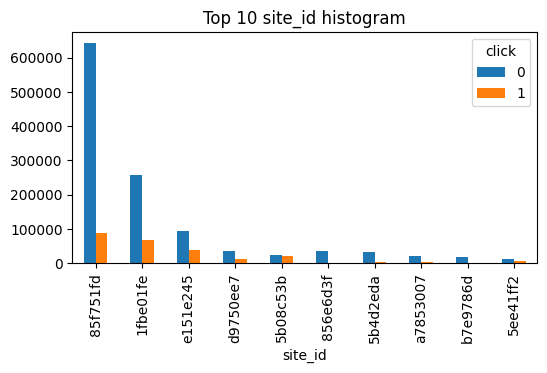

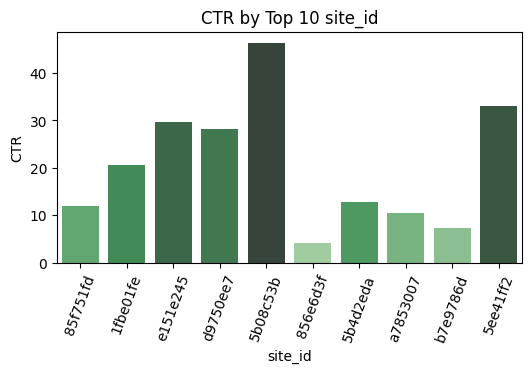

In [ ]:
FEATURE_NAME = 'site_id'
analysis_feature(FEATURE_NAME)

Frequency 상위 5개의 Site <br>
Frequency: 2% 이상 <br>
CTR: CTR 평균인 16%와 값이 많이 다르다. => 변별력을 갖는 Feature일 수 있다.


<h3>Site ID의 Impression 비중을 기준으로 Sorting해서 확인한 CTR </h3>

<b> Site ID Feature </b> <br>
Impression 비중이 2~16%대로 높은 Site ID의 CTR이 16%보다 많이 높다

<h2>Site Domain</h2>

There are 3545 site_domain in the data set
+----+---------------+-------------+-------+
|    | site_domain   |   frequency |   CTR |
|----+---------------+-------------+-------|
|  0 | c4e18dd6      |       37.43 | 12.28 |
|  1 | f3845767      |       16.03 | 20.69 |
|  2 | 7e091613      |        8.23 | 25.86 |
|  3 | 7687a86e      |        3.19 | 45.79 |
|  4 | 98572c79      |        2.45 | 27.63 |
|  5 | 16a36ef3      |        2.10 | 13.99 |
|  6 | 58a89a43      |        1.90 |  4.23 |
|  7 | 9d54950b      |        0.93 | 11.34 |
|  8 | b12b9f85      |        0.92 |  7.36 |
|  9 | 17d996e6      |        0.87 | 32.92 |
+----+---------------+-------------+-------+


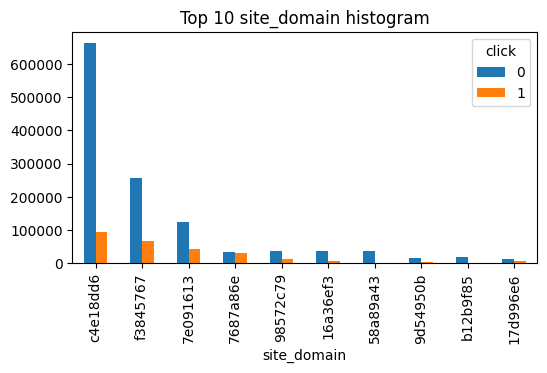

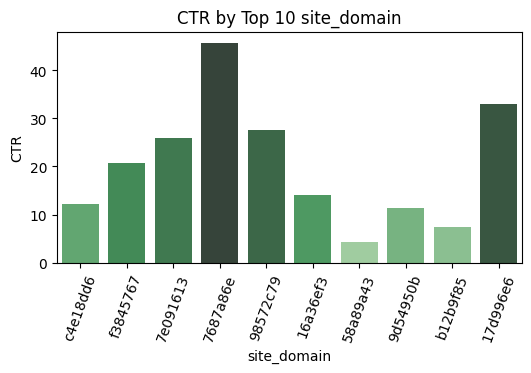

In [ ]:
FEATURE_NAME = 'site_domain'
analysis_feature(FEATURE_NAME)

질문 : Site Domain , Site ID는 서로 상관 없는건가?? 어떤 연관이 있는거지 ??

Top 5 Site Domain의 CTR이 전체 평균 CTR인 16%와 많은 차이가 있고, <br>
Frequency가 높다 (2% 이상)

<h2> Site Category</h2>

There are 22 site_category in the data set
+----+-----------------+-------------+-------+
|    | site_category   |   frequency |   CTR |
|----+-----------------+-------------+-------|
|  0 | 50e219e0        |       40.91 | 12.85 |
|  1 | f028772b        |       31.31 | 17.96 |
|  2 | 28905ebd        |       18.25 | 20.89 |
|  3 | 3e814130        |        7.53 | 28.15 |
|  4 | f66779e6        |        0.62 |  4.10 |
|  5 | 75fa27f6        |        0.40 | 10.79 |
|  6 | 335d28a8        |        0.34 |  9.37 |
|  7 | 76b2941d        |        0.26 |  2.94 |
|  8 | c0dd3be3        |        0.11 | 10.21 |
|  9 | 72722551        |        0.07 |  4.72 |
+----+-----------------+-------------+-------+


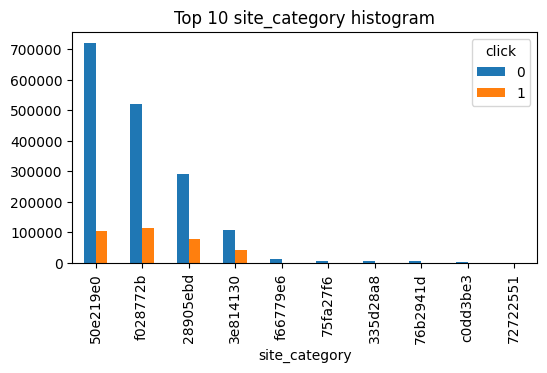

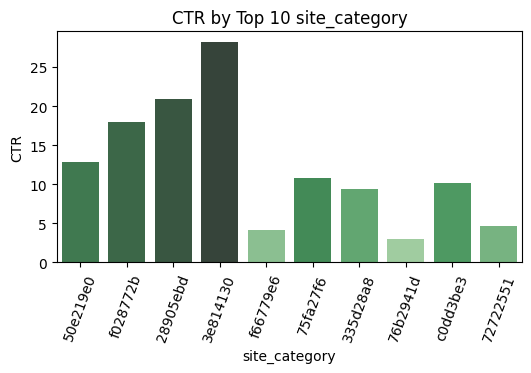

In [ ]:
FEATURE_NAME = 'site_category'
analysis_feature(FEATURE_NAME)

<h1>Device Features</h1>
<h2>Device ID</h2>

There are 280867 device_id in the data set
+----+-------------+-------------+-------+
|    | device_id   |   frequency |   CTR |
|----+-------------+-------------+-------|
|  0 | a99f214a    |       82.52 | 17.41 |
|  1 | 0f7c61dc    |        0.05 | 77.02 |
|  2 | c357dbff    |        0.05 | 63.10 |
|  3 | 936e92fb    |        0.03 |  6.80 |
|  4 | afeffc18    |        0.02 | 23.15 |
|  5 | cef4c8cc    |        0.01 | 24.02 |
|  6 | 987552d1    |        0.01 |  0.00 |
|  7 | 28dc8687    |        0.01 |  0.00 |
|  8 | b09da1c4    |        0.01 | 12.95 |
|  9 | d857ffbb    |        0.01 | 22.87 |
+----+-------------+-------------+-------+


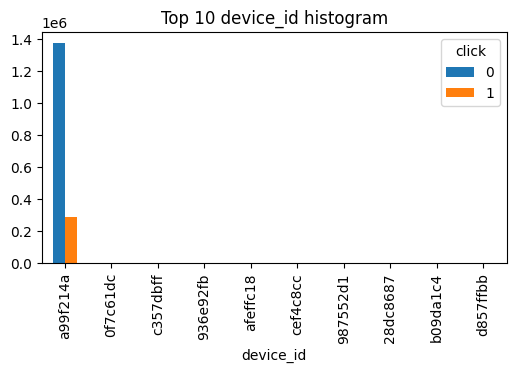

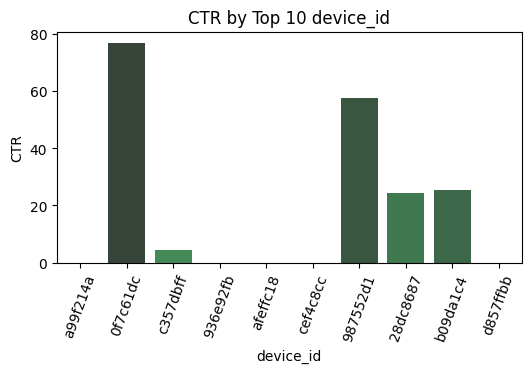

In [ ]:
FEATURE_NAME = 'device_id'
analysis_feature(FEATURE_NAME)

<h2>Device IP</h2>

There are 969474 device_ip in the data set
+----+-------------+-------------+-------+
|    | device_ip   |   frequency |   CTR |
|----+-------------+-------------+-------|
|  0 | 6b9769f2    |        0.51 | 22.14 |
|  1 | 431b3174    |        0.34 | 19.10 |
|  2 | 2f323f36    |        0.22 | 10.31 |
|  3 | 930ec31d    |        0.22 |  9.84 |
|  4 | af9205f9    |        0.22 |  9.79 |
|  5 | af62faf4    |        0.22 | 10.34 |
|  6 | 285aa37d    |        0.21 |  9.64 |
|  7 | 009a7861    |        0.21 |  9.48 |
|  8 | d90a7774    |        0.21 |  9.39 |
|  9 | 6394f6f6    |        0.20 |  9.08 |
+----+-------------+-------------+-------+


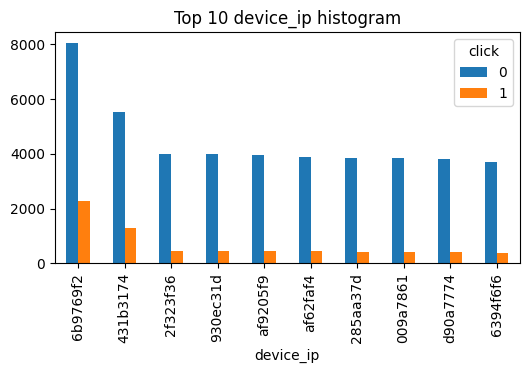

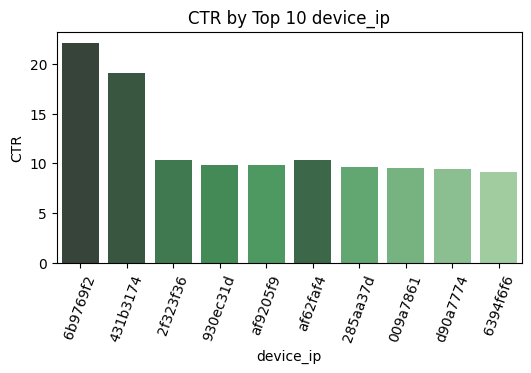

In [ ]:
FEATURE_NAME = 'device_ip'
analysis_feature(FEATURE_NAME)

Top 1,2 Class의 CTR 비율이 22%, 19%로 높지만, <br>
모든 Class의 Frequency가 1% 미만으로 낮아서, Importance가 떨어지는 Feature일 것 같다 <br>


There are 5765 device_model in the data set
+----+----------------+-------------+-------+
|    | device_model   |   frequency |   CTR |
|----+----------------+-------------+-------|
|  0 | 8a4875bd       |        6.08 | 13.84 |
|  1 | 1f0bc64f       |        3.52 | 22.37 |
|  2 | d787e91b       |        3.45 | 22.29 |
|  3 | 76dc4769       |        1.92 | 18.71 |
|  4 | be6db1d7       |        1.84 | 18.79 |
|  5 | a0f5f879       |        1.61 | 16.88 |
|  6 | 4ea23a13       |        1.60 | 21.40 |
|  7 | 7abbbd5c       |        1.57 | 17.67 |
|  8 | ecb851b2       |        1.51 | 18.18 |
|  9 | d4897fef       |        1.20 | 17.09 |
+----+----------------+-------------+-------+


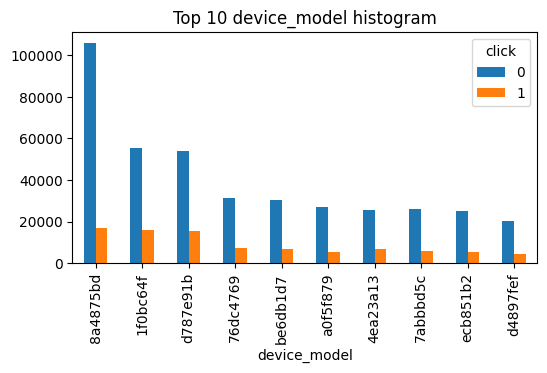

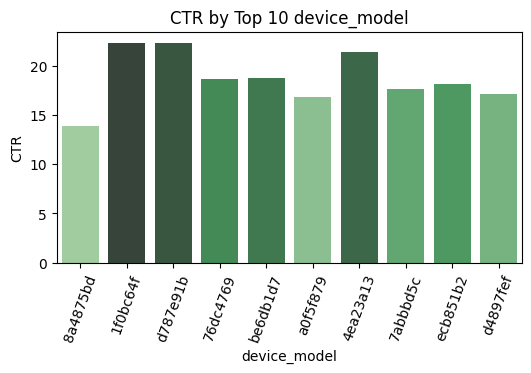

In [ ]:
FEATURE_NAME = 'device_model'
analysis = analysis_feature(FEATURE_NAME)

<h2>Device Type</h2>

There are 5 device_type in the data set
+----+---------------+-------------+-------+
|    |   device_type |   frequency |   CTR |
|----+---------------+-------------+-------|
|  0 |          1.00 |       92.28 | 16.93 |
|  1 |          0.00 |        5.50 | 20.77 |
|  2 |          4.00 |        1.91 |  9.51 |
|  3 |          5.00 |        0.32 | 10.02 |
|  4 |          2.00 |        0.00 |  0.00 |
+----+---------------+-------------+-------+


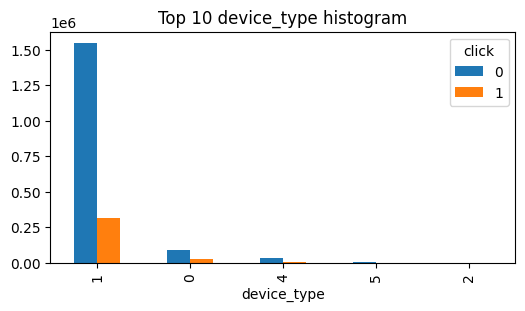

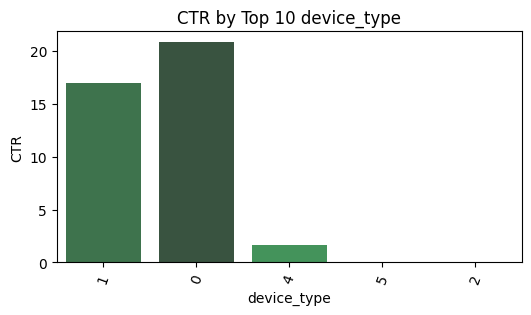

In [ ]:
FEATURE_NAME = 'device_type'
analysis = analysis_feature(FEATURE_NAME)

1. 대부분을 차지하는 Class 의 CTR이 16%로, 평균 CTR과 큰 차이가 없다. <br>
2. 분포 2위인 Class의 CTR은 20%로 평균 CTR과 차이가 있다.

Device Type 1인 Data에서

각 Device Type에 대해서 시간대에 대한 Click의 분포가 다른지 확인해봤다 <br>
아래와 같은 분석이 Feature Cross 분석인 것 같다 <br>

다른 Device Type에 비해서 확실히 차이나는 형태를 보이는것 같지는 않다. <br>
이런 식으로 Feature Cross 를 EDA 단계에서도 Categorical한 변수에 대해서도 분석할 수 있을까?

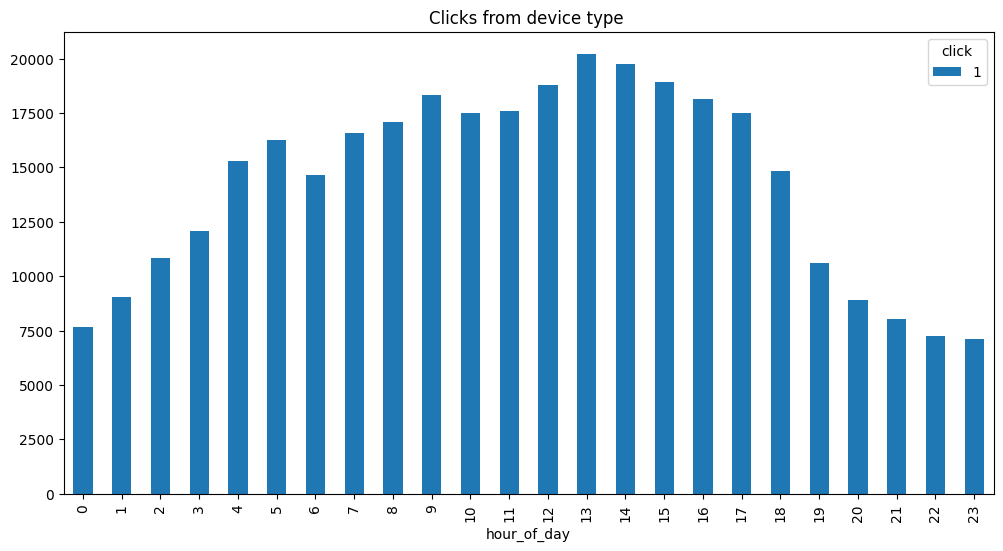

In [ ]:
# 전체 Dataset에 대해서 확인한 시간별 Click 수의 분포
df_click.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Clicks from device type ", figsize=(12,6));

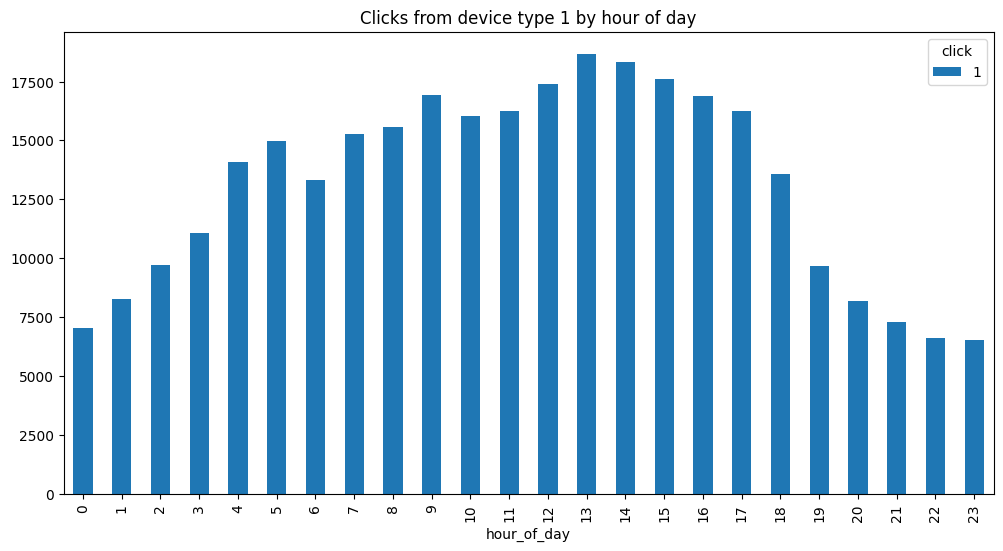

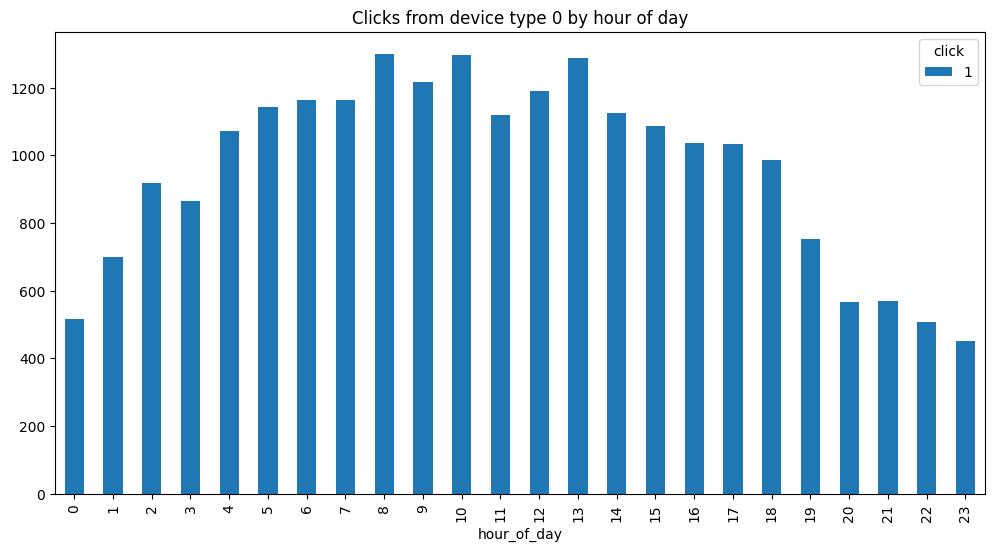

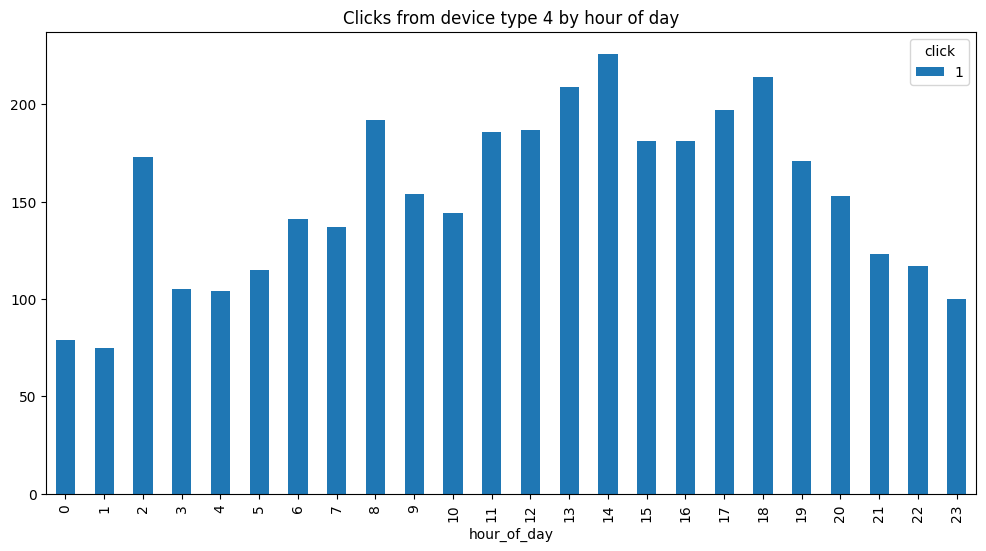

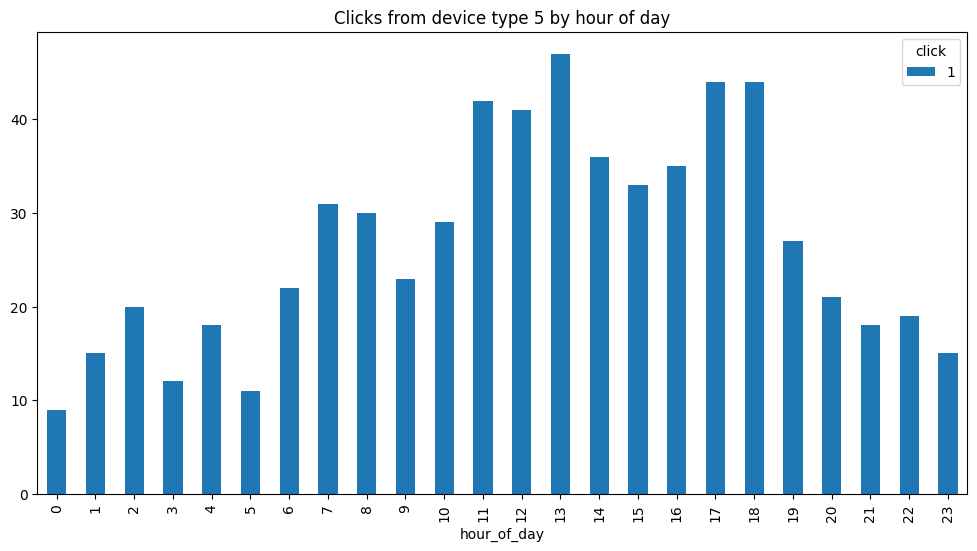

In [ ]:
# 각 Device Type에 대한 시간별 Click 수의 분포
for i in [1, 0, 4, 5, 2]:
    try:
        df_click[df_click['device_type']==i].groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Clicks from device type {} by hour of day".format(i), figsize=(12,6));
    except:
        pass

Device Type과 Device Model간의 관계 확인 <br>
- 포함 관계가 성립하는게 상식,
- 하나의 Device Model은 하나의 Device Type에만 포함되어야 하는게 상식
- Device Type : Device Model = 1 : N 이 성립 되어야 하는게 상식
- 결과를 확인해보면 전체 Device Model의 13%는 여러 Device Type으로 기록이 되어있다
- ...잘못 된거 아닌가? Major Class로 합쳐져야 하는거 아닐까? - 그게 맞을 것 같은데, Device Type Feature의 Importance가 크면, 그런식으로 정제해야 될것 같은데, 큰지 아직 모르니까. 큰 신경 안써도 되지 않을까?

In [ ]:
def analysis_device_model_type():
    device_type_dict = {}
    for idx in train.index:
        device_model = train['device_model'][idx]
        device_type = train['device_type'][idx]

        if device_model in device_type_dict:
            if device_type not in device_type_dict[device_model]:
                device_type_dict[device_model].append(device_type)
        else:
            device_type_dict[device_model] = [device_type]

    count = 0
    for device_model, device_type in device_type_dict.items():
        if len(device_type) > 1:
            count += 1

    print('하나의 Model이 여러 Type으로 기록된 비율 : {:.2f}%'.format(count / len(device_type_dict.keys()) * 100))

<h1>App Features</h1>

<h2>App ID</h2>

There are 3912 app_id in the data set
+----+----------+-------------+-------+
|    | app_id   |   frequency |   CTR |
|----+----------+-------------+-------|
|  0 | ecad2386 |       63.90 | 19.84 |
|  1 | 92f5800b |        3.86 |  1.90 |
|  2 | e2fcccd2 |        2.79 | 19.54 |
|  3 | febd1138 |        1.88 |  4.88 |
|  4 | 9c13b419 |        1.88 | 30.54 |
|  5 | 7358e05e |        1.51 | 19.10 |
|  6 | a5184c22 |        1.21 | 24.60 |
|  7 | d36838b1 |        1.12 |  6.85 |
|  8 | 685d1c4c |        1.00 |  7.36 |
|  9 | 54c5d545 |        0.97 | 12.76 |
+----+----------+-------------+-------+


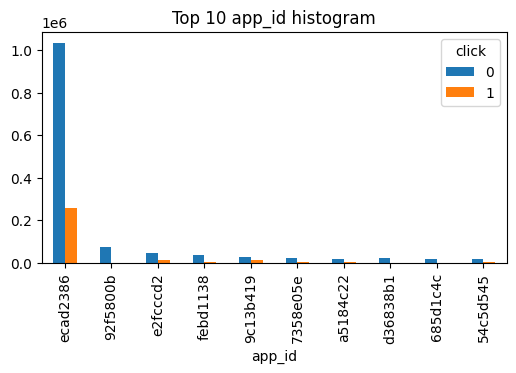

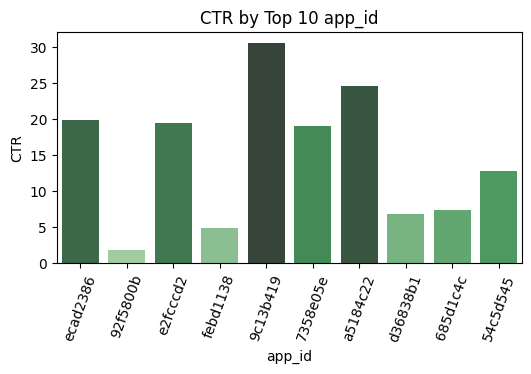

In [ ]:
FEATURE_NAME = 'app_id'
analysis = analysis_feature(FEATURE_NAME)

In [ ]:
a=4
analysis.top10_summary_df.head()

,app_id,frequency,CTR
0,ecad2386,63.895053,19.841675
1,92f5800b,3.861850,1.904591
2,e2fcccd2,2.793409,19.535403
3,febd1138,1.882814,4.876574
4,9c13b419,1.877023,30.544275


<h2>App Domain</h2>

보기에는 이 Feature도 Top 5 Feature가 Frequency가 높고, CTR이 전체평균과 다른듯 하다

There are 241 app_domain in the data set
+----+--------------+-------------+-------+
|    | app_domain   |   frequency |   CTR |
|----+--------------+-------------+-------|
|  0 | 7801e8d9     |       67.36 | 19.47 |
|  1 | 2347f47a     |       12.97 | 13.88 |
|  2 | ae637522     |        4.67 |  2.40 |
|  3 | 5c5a694b     |        2.79 | 19.53 |
|  4 | 82e27996     |        1.88 |  4.88 |
|  5 | d9b5648e     |        1.77 | 11.07 |
|  6 | 0e8616ad     |        1.63 |  6.96 |
|  7 | b9528b13     |        1.58 | 18.45 |
|  8 | b8d325c3     |        1.32 | 23.11 |
|  9 | aefc06bd     |        0.73 |  7.05 |
+----+--------------+-------------+-------+


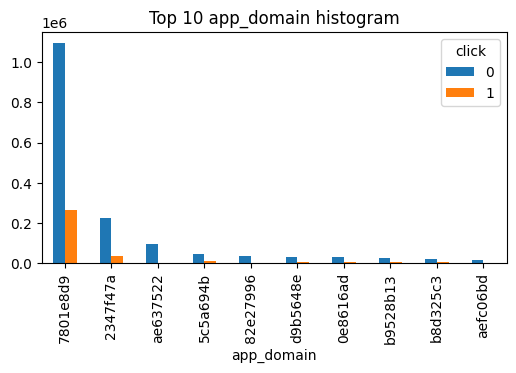

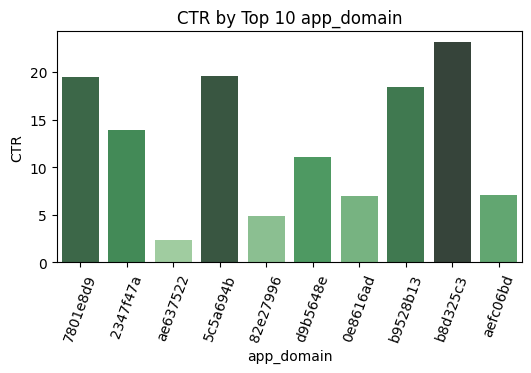

In [ ]:
FEATURE_NAME = 'app_domain'
analysis = analysis_feature(FEATURE_NAME)

<h2>App Category</h2>

There are 28 app_category in the data set
+----+----------------+-------------+-------+
|    | app_category   |   frequency |   CTR |
|----+----------------+-------------+-------|
|  0 | 07d7df22       |       64.72 | 19.89 |
|  1 | 0f2161f8       |       23.64 | 10.82 |
|  2 | cef3e649       |        4.27 |  9.45 |
|  3 | 8ded1f7a       |        3.64 |  9.07 |
|  4 | f95efa07       |        2.84 | 24.77 |
|  5 | d1327cf5       |        0.31 | 12.84 |
|  6 | 09481d60       |        0.14 | 15.43 |
|  7 | dc97ec06       |        0.13 | 15.68 |
|  8 | 75d80bbe       |        0.09 |  8.60 |
|  9 | fc6fa53d       |        0.06 |  4.91 |
+----+----------------+-------------+-------+


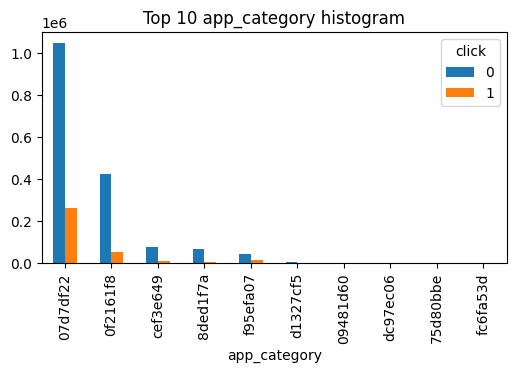

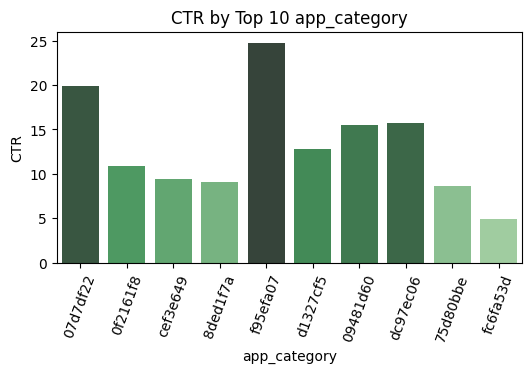

In [ ]:
FEATURE_NAME = 'app_category'
analysis = analysis_feature(FEATURE_NAME)

<h1>Categorical Features</h1>

In [ ]:
features_list = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

There are 7 C1 in the data set
+----+---------+-------------+-------+
|    |      C1 |   frequency |   CTR |
|----+---------+-------------+-------|
|  0 | 1005.00 |       91.88 | 16.95 |
|  1 | 1002.00 |        5.50 | 20.77 |
|  2 | 1010.00 |        2.22 |  9.58 |
|  3 | 1012.00 |        0.28 | 16.71 |
|  4 | 1007.00 |        0.08 |  4.52 |
|  5 | 1001.00 |        0.02 |  3.29 |
|  6 | 1008.00 |        0.01 | 13.79 |
+----+---------+-------------+-------+


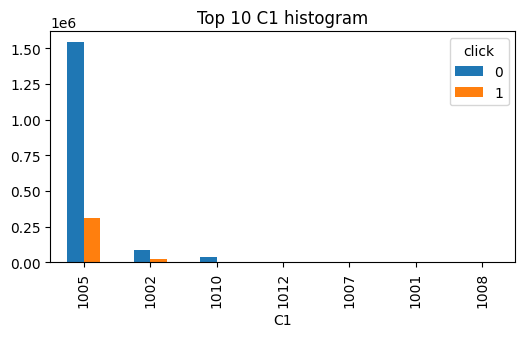

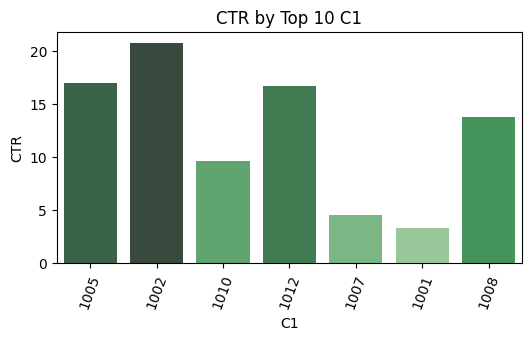

In [ ]:
analysis = analysis_feature('C1')

There are 2368 C14 in the data set
+----+----------+-------------+-------+
|    |      C14 |   frequency |   CTR |
|----+----------+-------------+-------|
|  0 |  4687.00 |        2.34 | 25.11 |
|  1 | 21611.00 |        2.24 |  5.59 |
|  2 | 21191.00 |        1.91 |  1.92 |
|  3 | 21189.00 |        1.90 |  1.99 |
|  4 | 19771.00 |        1.81 | 11.29 |
|  5 | 19772.00 |        1.80 | 11.08 |
|  6 | 16208.00 |        1.63 | 12.13 |
|  7 | 20108.00 |        1.45 | 25.19 |
|  8 |  8330.00 |        1.39 | 14.28 |
|  9 | 19950.00 |        1.30 | 12.21 |
+----+----------+-------------+-------+


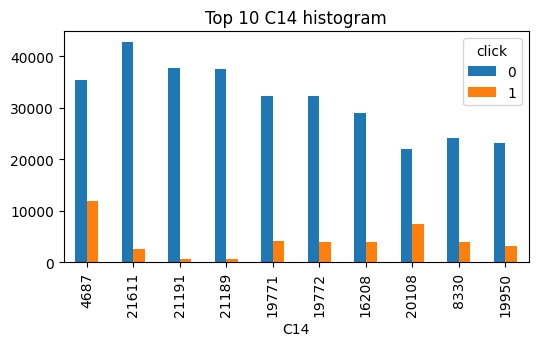

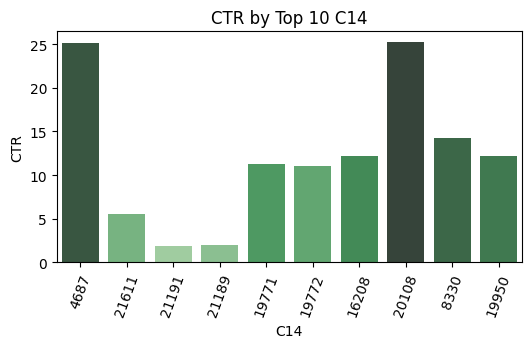

In [ ]:
analysis = analysis_feature('C14')

There are 8 C15 in the data set
+----+---------+-------------+-------+
|    |     C15 |   frequency |   CTR |
|----+---------+-------------+-------|
|  0 |  320.00 |       93.28 | 15.86 |
|  1 |  300.00 |        5.76 | 35.95 |
|  2 |  216.00 |        0.75 | 12.68 |
|  3 |  728.00 |        0.18 |  5.53 |
|  4 |  120.00 |        0.01 |  1.17 |
|  5 | 1024.00 |        0.01 | 25.17 |
|  6 |  480.00 |        0.01 | 31.07 |
|  7 |  768.00 |        0.00 | 38.60 |
+----+---------+-------------+-------+


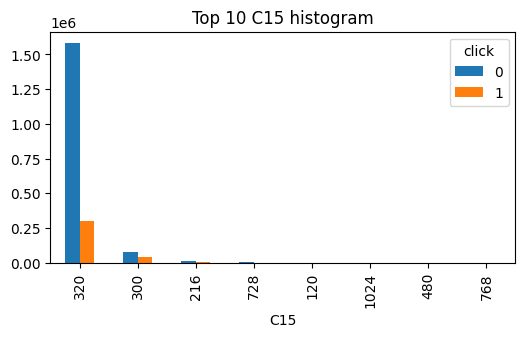

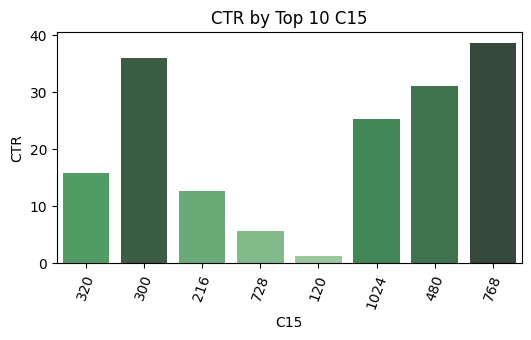

In [ ]:
analysis = analysis_feature('C15')

There are 9 C16 in the data set
+----+---------+-------------+-------+
|    |     C16 |   frequency |   CTR |
|----+---------+-------------+-------|
|  0 |   50.00 |       94.32 | 15.84 |
|  1 |  250.00 |        4.47 | 41.97 |
|  2 |   36.00 |        0.75 | 12.68 |
|  3 |  480.00 |        0.25 | 21.53 |
|  4 |   90.00 |        0.18 |  5.53 |
|  5 |   20.00 |        0.01 |  1.17 |
|  6 |  768.00 |        0.01 | 25.17 |
|  7 |  320.00 |        0.01 | 31.07 |
|  8 | 1024.00 |        0.00 | 38.60 |
+----+---------+-------------+-------+


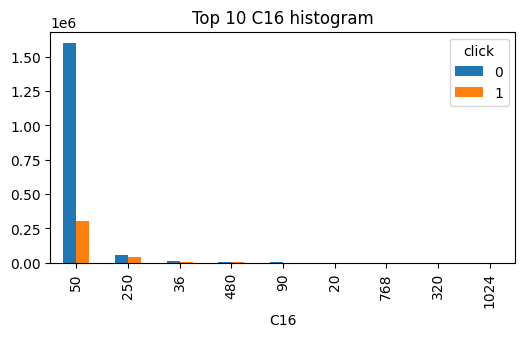

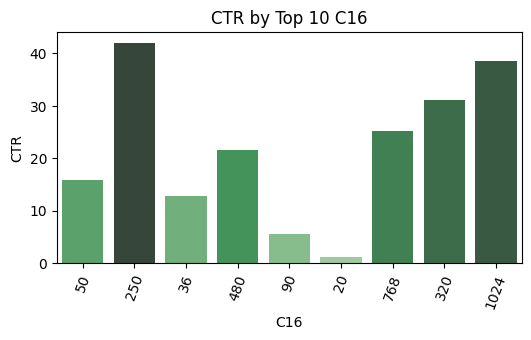

In [ ]:
analysis = analysis_feature('C16')

There are 426 C17 in the data set
+----+---------+-------------+-------+
|    |     C17 |   frequency |   CTR |
|----+---------+-------------+-------|
|  0 | 1722.00 |       11.16 | 19.07 |
|  1 | 2424.00 |        3.80 |  1.95 |
|  2 | 2227.00 |        3.64 | 11.20 |
|  3 | 1800.00 |        2.95 | 12.15 |
|  4 |  423.00 |        2.34 | 25.11 |
|  5 | 2480.00 |        2.27 |  5.62 |
|  6 | 2502.00 |        2.10 | 19.86 |
|  7 | 2528.00 |        2.05 | 13.28 |
|  8 | 2506.00 |        1.99 | 10.08 |
|  9 | 2374.00 |        1.86 | 25.14 |
+----+---------+-------------+-------+


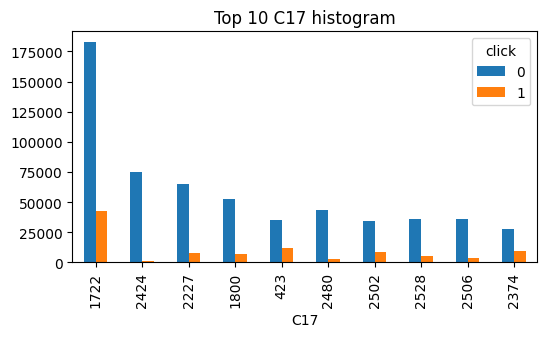

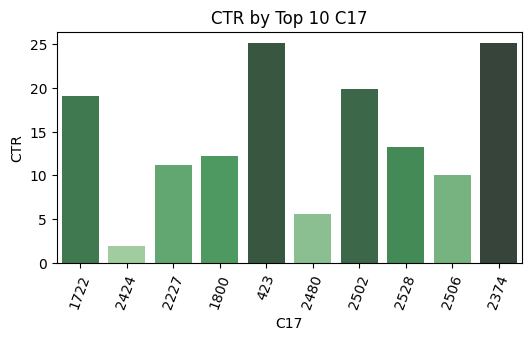

In [ ]:
analysis = analysis_feature('C17')

There are 4 C18 in the data set
+----+-------+-------------+-------+
|    |   C18 |   frequency |   CTR |
|----+-------+-------------+-------|
|  0 |  0.00 |       41.85 | 15.84 |
|  1 |  3.00 |       33.81 | 14.53 |
|  2 |  2.00 |       17.60 | 29.60 |
|  3 |  1.00 |        6.74 |  3.44 |
+----+-------+-------------+-------+


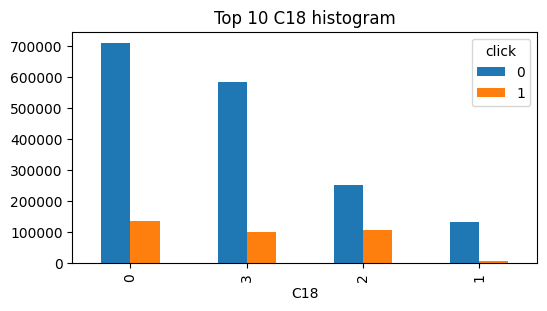

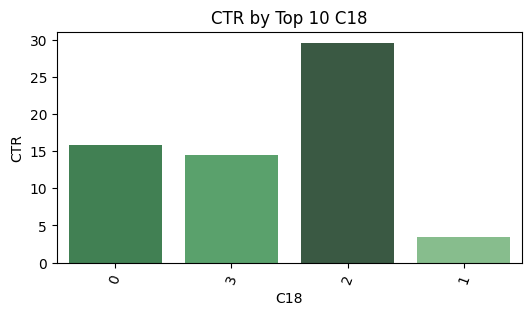

In [ ]:
analysis = analysis_feature('C18')

There are 68 C19 in the data set
+----+---------+-------------+-------+
|    |     C19 |   frequency |   CTR |
|----+---------+-------------+-------|
|  0 |   35.00 |       30.11 | 16.73 |
|  1 |   39.00 |       21.84 | 24.50 |
|  2 |  167.00 |        7.77 | 16.10 |
|  3 |  161.00 |        3.94 |  2.30 |
|  4 |   47.00 |        3.59 | 17.54 |
|  5 | 1327.00 |        2.70 | 23.46 |
|  6 |  297.00 |        2.50 |  7.24 |
|  7 |  163.00 |        2.29 |  9.31 |
|  8 |  175.00 |        2.03 | 11.82 |
|  9 |  679.00 |        1.82 | 10.86 |
+----+---------+-------------+-------+


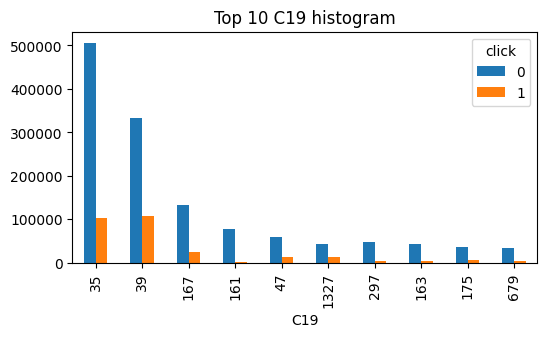

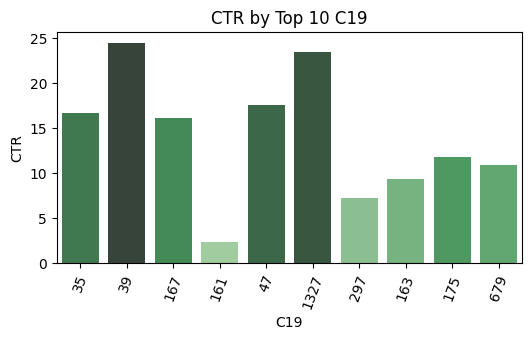

In [ ]:
analysis = analysis_feature('C19')

There are 165 C20 in the data set
+----+-----------+-------------+-------+
|    |       C20 |   frequency |   CTR |
|----+-----------+-------------+-------|
|  0 |     -1.00 |       46.84 | 19.28 |
|  1 | 100084.00 |        6.04 | 21.48 |
|  2 | 100148.00 |        4.44 | 23.50 |
|  3 | 100111.00 |        4.25 |  8.68 |
|  4 | 100077.00 |        3.90 | 17.37 |
|  5 | 100075.00 |        3.82 | 16.25 |
|  6 | 100081.00 |        3.29 | 19.05 |
|  7 | 100083.00 |        2.65 | 19.77 |
|  8 | 100156.00 |        2.55 |  9.75 |
|  9 | 100193.00 |        1.75 |  2.32 |
+----+-----------+-------------+-------+


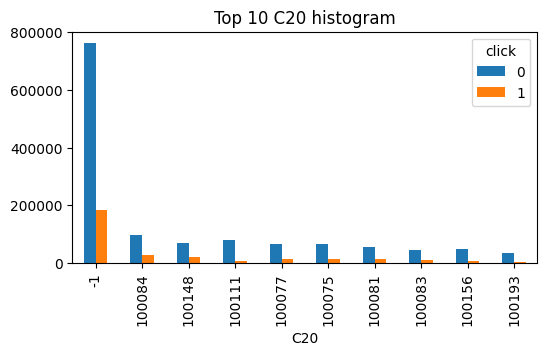

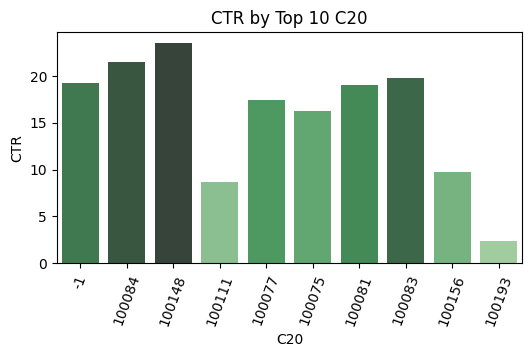

In [ ]:
analysis = analysis_feature('C20')

There are 60 C21 in the data set
+----+--------+-------------+-------+
|    |    C21 |   frequency |   CTR |
|----+--------+-------------+-------|
|  0 |  23.00 |       21.99 | 21.19 |
|  1 | 221.00 |       12.47 | 16.73 |
|  2 |  79.00 |       11.41 | 18.89 |
|  3 |  48.00 |        5.34 | 13.81 |
|  4 |  71.00 |        5.24 |  2.80 |
|  5 |  61.00 |        5.09 |  6.59 |
|  6 | 157.00 |        4.60 | 11.59 |
|  7 |  32.00 |        4.41 | 23.31 |
|  8 |  33.00 |        3.71 | 39.40 |
|  9 |  52.00 |        2.97 | 27.09 |
+----+--------+-------------+-------+


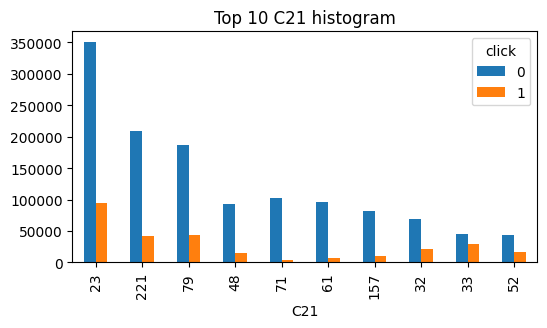

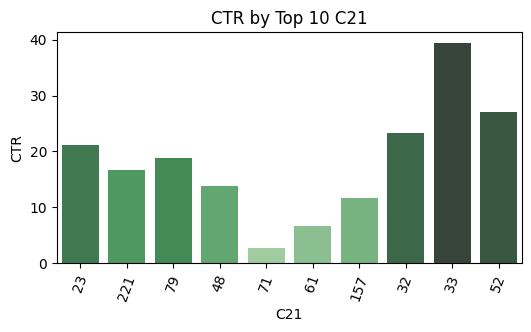

In [ ]:
analysis = analysis_feature('C21')

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
def get_chi_square_test_result(train, cate1, cate2):
    table = pd.crosstab(train[cate1], train[cate2])
    result_test = chi2_contingency(table)
    return result_test

def show_result(result_test):
    print("Test Value : {:.2f}".format(result_test[0]))
    print("P Vale : {}".format(result_test[1]))
    print("Degree of Freedom : {:.2f}".format(result_test[2]))

In [ ]:
columns = train.columns

In [ ]:
# for col1 in columns:
#     for col2 in columns:
#         if col1 == col2:
#             continue
#         if col1 == 'id':
#             continue
#         if col2 == 'id':
#             continue
#         result_test = get_chi_square_test_result(train, col1, col2)
#         if result_test[1] == 0:
#             continue
#         print("col1 : {}, col2 : {}".format(col1, col2))
#         show_result(result_test)

In [ ]:
cate1 = 'device_type'
cate2 = 'site_domain'
table = pd.crosstab(train[cate1], train[cate2])
result_test = get_chi_square_test_result(train, cate1, cate2)
show_result(result_test)

Test Value : 1306780.28
P Vale : 0.0
Degree of Freedom : 14176.00


In [ ]:
table

site_domain,005b495a,00847768,00863f59,00abf1a6,00bc3f51,00dda4fc,00e1b9c0,012af8ba,01302556,0150cc3e,...,ff8c5d6f,ffa09d08,ffae26f5,ffb2d478,ffb983b1,ffc492ad,ffdc5fcd,ffde5f3b,fff32e94,fff602a2
device_type,,,,,,,,,,,,,,,,,,,,,
0,153,26,10,8,1,11,0,19,0,398,...,0,5,1,2,0,7,1,2,1,0
1,0,23,0,0,0,0,170,2,3,64,...,16,0,0,0,1,0,0,0,0,97
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
expected = pd.DataFrame(result_test[3])

In [ ]:
expected.astype(int)

,0,1,2,3,4,5,6,7,8,9,...,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544
0,8,2,0,0,0,0,9,1,0,25,...,0,0,0,0,0,0,0,0,0,5
1,141,45,9,7,0,10,156,19,2,426,...,14,4,0,1,0,6,0,1,0,89
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,3,0,0,8,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


There are 7 C1 in the data set
+----+---------+-------------+-------+
|    |      C1 |   frequency |   CTR |
|----+---------+-------------+-------|
|  0 | 1005.00 |       91.88 | 16.95 |
|  1 | 1002.00 |        5.50 | 20.77 |
|  2 | 1010.00 |        2.22 |  9.58 |
|  3 | 1012.00 |        0.28 | 16.71 |
|  4 | 1007.00 |        0.08 |  4.52 |
|  5 | 1001.00 |        0.02 |  3.29 |
|  6 | 1008.00 |        0.01 | 13.79 |
+----+---------+-------------+-------+


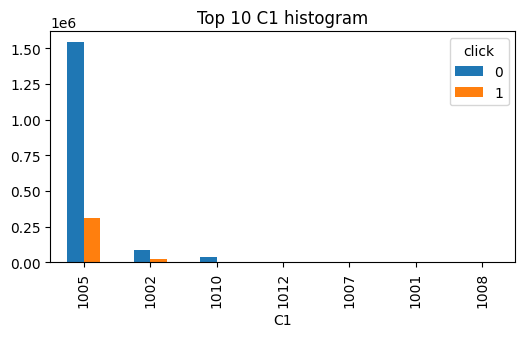

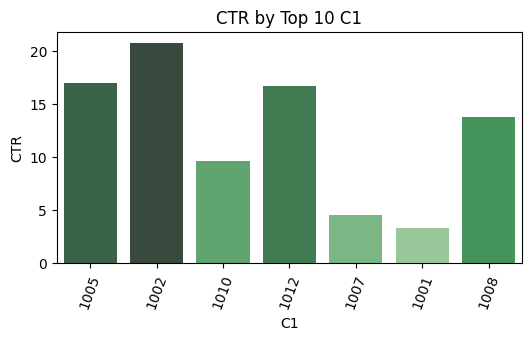

In [ ]:
FEATURE_NAME = 'C1'
analysis_feature(FEATURE_NAME)

In [ ]:
# import pandas as pd
# import numpy as np
# from scipy.stats import chi2_contingency
# import matplotlib.pyplot as plt
# import seaborn as sns

# def cramerV(label,x):
#     confusion_matrix = pd.crosstab(label, x)
#     chi2 = chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     r,k = confusion_matrix.shape
#     phi2 = chi2/n
#     phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
#     rcorr = r - ((r - 1) ** 2) / ( n - 1 )
#     kcorr = k - ((k - 1) ** 2) / ( n - 1 )
#     try:
#         if min((kcorr - 1),(rcorr - 1)) == 0:
#             warnings.warn(
#             "Unable to calculate Cramer's V using bias correction. Consider not using bias correction",RuntimeWarning)
#             v = 0
#             print("If condition Met: ",v)
#         else:
#             v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
#             print("Else condition Met: ",v)
#     except:
#         print("inside error")
#         v = 0
#     return v
# def plot_cramer(df):
#     cramer = pd.DataFrame(index=df.columns,columns=df.columns)
#     for column_of_interest in df.columns:
#         try:
#             temp = {}

#             columns = df.columns
#             for j in range(0,len(columns)):
#                 v = cramerV(df[column_of_interest],df[columns[j]])
#                 cramer.loc[column_of_interest,columns[j]] = v
#                 if (column_of_interest==columns[j]):
#                     pass
#                 else:
#                     temp[columns[j]] = v
#             cramer.fillna(value=np.nan,inplace=True)
#         except:
#             print('Dropping row:',column_of_interest)
#             pass
#     plt.figure(figsize=(7,7))
#     sns.heatmap(cramer,annot=True,fmt='.2f')

#     plt.title("Cross Correlation plot on Dataframe with Cramer's Correlation Values")
#     plt.show()

# plot_cramer(train)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

In [ ]:
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_of_day',
       'day_of_week'],
      dtype='object')

In [ ]:
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_of_day',
       'day_of_week'],
      dtype='object')

In [ ]:
targets = ['banner_pos',
          'site_id', 'site_domain', 'site_category',
          'app_id', 'app_domain', 'app_category',
          'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type',
          'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21',
          'hour_of_day', 'day_of_week']

In [ ]:
train_dropped = train.drop(['id', 'hour'], axis=1)

In [ ]:
df = pd.get_dummies(train_dropped)

KeyboardInterrupt: 

In [ ]:
df

In [ ]:
column_trans = ColumnTransformer(transformers=
        [('cat', OneHotEncoder(), selector(dtype_include="object"))],
        remainder='drop')

In [ ]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

In [ ]:
pipeline = Pipeline([('prep',column_trans),
                     ('clf', clf)])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train[targets], train['click'], test_size=0.3, random_state=0)

In [ ]:
params = {"criterion":["gini", "entropy"], "max_depth":range(1,20)}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_estimator_, grid_search.best_params_

In [ ]:
pipeline.fit(X_train, y_train)